In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
import jax
import tensorflow_probability.substrates.jax as tfp
import jax.numpy as jnp
from jax import random,vmap, grad
tfpd = tfp.distributions
from bo import sampler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from bo_utils import input_unstandardize
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

In [2]:
input_file = './cosmo_input/LCDM_2D.yaml'

cosmo = sampler(ndim=2,cobaya_model=True,input_file=input_file,seed=1,max_steps=12, nstart=4)

[Ameeks-iMac.local:13950] shmem: mmap: an error occurred while determining whether or not /var/folders/17/bb86shf11bg907n09zjw75680000gn/T//ompi.Ameeks-iMac.501/jf.0/3202220032/sm_segment.Ameeks-iMac.501.bede0000.0 could be created.


[model] *WARNING* Ignored blocks/options: ['output']


INFO:camb:`camb` module loaded successfully from /opt/homebrew/Caskroom/miniconda/base/envs/cosmo/lib/python3.12/site-packages/camb


[camb] `camb` module loaded successfully from /opt/homebrew/Caskroom/miniconda/base/envs/cosmo/lib/python3.12/site-packages/camb


INFO:[BO]: Running the sampler with the following params ['logA', 'ns']
INFO:[BO]: Parameter bounds 
[[2.95 3.15]
 [0.92 1.  ]]
INFO:[BO]: Initial values to evaluate 
{'logA': array([2.98109306, 0.96709979]), 'ns': array([3.11767694, 0.92832481])}
INFO:[BO]: Initial loglikes 
[[-1271.96522699]
 [-1640.98623761]
 [ -791.55844185]
 [ -550.17253703]]
sample: 100%|██████████| 512/512 [00:00<00:00, 914.87it/s, 3 steps of size 4.11e-01. acc. prob=0.76]
INFO:[GP]: MCMC elapsed time: 1.75s


In [3]:
cosmo.run()

INFO:[NS]: Nested Sampling took 2.11s
INFO:[NS]: jaxns did 22099 likelihood evaluations
INFO:[BO]: LogZ info :logz_mean: = -550.4019, dlogz: = 0.4471, 
INFO:[AQ]: Acquisition optimization took 2.01 s
INFO:[BO]: Next point at x = {'logA': 3.0410857036868935, 'ns': 0.9478387859192426} with acquisition function value = 4.7362e-04
INFO:[BO]: Loglike at new point = [[-525.99046088]], current best loglike = [-550.17253703] at {'logA': 3.0346947317942976, 'ns': 0.9474799045175314} 
sample: 100%|██████████| 512/512 [00:00<00:00, 1004.16it/s, 11 steps of size 2.75e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 0.86s
INFO:[BO]: ----------------------Step 1 complete----------------------

INFO:[NS]: Nested Sampling took 1.55s
INFO:[NS]: jaxns did 19672 likelihood evaluations
INFO:[BO]: LogZ info :logz_mean: = -523.4721, dlogz: = 0.4290, 
INFO:[AQ]: Acquisition optimization took 1.46 s
INFO:[BO]: Next point at x = {'logA': 3.045890574552309, 'ns': 0.9516269788609412} with acquisition function 

In [4]:
from fb_gp import sample_GP_NUTS

train_x = input_unstandardize(cosmo.train_x,cosmo.param_bounds)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
samples = sample_GP_NUTS(gp = cosmo.gp,rng_key=rng_key)

samples = input_unstandardize(samples,cosmo.param_bounds)

sample: 100%|██████████| 1024/1024 [00:00<00:00, 1961.98it/s, 3 steps of size 9.44e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]      0.47      0.01      0.47      0.46      0.48    230.33      1.00
      x[1]      0.56      0.04      0.57      0.51      0.63    237.31      1.00

Number of divergences: 0
MCMC took 1.1411 s


In [5]:
print(cosmo.bounds_dict)

{'logA': array([2.95, 3.15]), 'ns': array([0.92, 1.  ])}


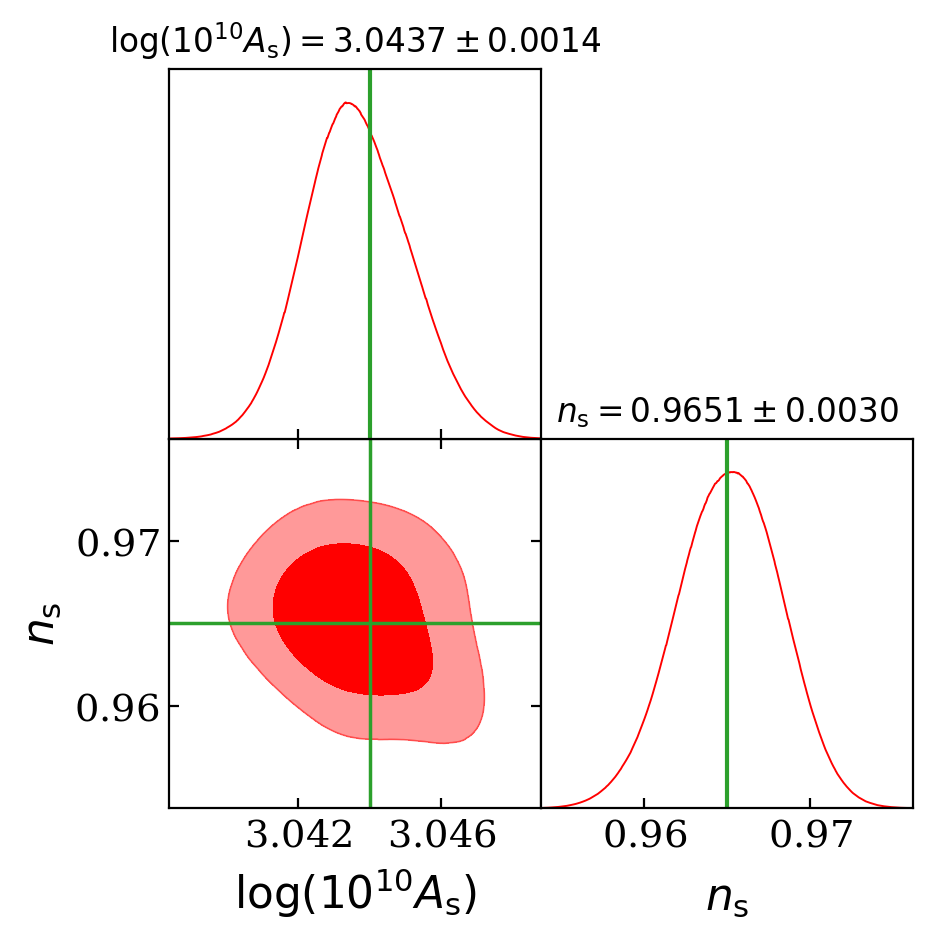

In [6]:
# ranges = dict(zip())

means  = [3.044,0.965]

markers = dict(zip(cosmo.param_list,means))

gp_samples_nuts = MCSamples(samples=samples,names=cosmo.param_list, labels = cosmo.param_labels,ranges=cosmo.bounds_dict)
g = plots.get_subplot_plotter(subplot_size=2.4,subplot_size_ratio=1)
# for s in [gp_samples,gp_samples_nuts,true_samples]:
#         print(f"".join(f"{str(s.getInlineLatex(p,limit=1))}") for p in names)
# # g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples_nuts], cosmo.param_list,filled=[True,False,False],contour_colors=['red','blue','black'],title_limit=1,
                markers = markers,marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'}) # type: ignore
#                                 legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution','HMC on GP fit'],
#                                 contour_lws=[1,1.5,1.],markers = dict(zip(names,f_mean)),
#                                 marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore


for i in range(cosmo.ndim):
    ax = g.subplots[i,i]
    ax.axvline(means[i], color='C2', ls='-')
    for j in range(i+1,cosmo.ndim):
        ax = g.subplots[j,i]
        ax.scatter(train_x[:,i],train_x[:,j],alpha=0.2,color='b',s=20)


### 3D example

In [7]:
input_file = './cosmo_input/LCDM_3D.yaml'

cosmo = sampler(ndim=3,cobaya_model=True,input_file=input_file,seed=1,max_steps=42, nstart=8,mc_points_size=32)

cosmo.run()

[model] *WARNING* Ignored blocks/options: ['output']


INFO:camb:`camb` module loaded successfully from /opt/homebrew/Caskroom/miniconda/base/envs/cosmo/lib/python3.12/site-packages/camb


[camb] `camb` module loaded successfully from /opt/homebrew/Caskroom/miniconda/base/envs/cosmo/lib/python3.12/site-packages/camb


INFO:[BO]: Running the sampler with the following params ['logA', 'ns', 'ombh2']
INFO:[BO]: Parameter bounds 
[[2.95 3.15]
 [0.92 1.  ]
 [0.01 0.03]]
INFO:[BO]: Initial values to evaluate 
{'logA': array([2.98109306, 0.96709979, 0.02215064]), 'ns': array([3.10397176, 0.92454979, 0.01158143]), 'ombh2': array([3.06434893, 0.98378956, 0.02709552])}
INFO:[BO]: Initial loglikes 
[[ -1255.32040393]
 [-17011.09517576]
 [ -2501.87378095]
 [ -3823.70230091]
 [ -8083.34771249]
 [  -779.23440076]
 [ -5510.80638695]
 [ -4456.90781286]]
sample: 100%|██████████| 512/512 [00:00<00:00, 669.40it/s, 15 steps of size 2.81e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 1.41s
INFO:[NS]: Nested Sampling took 2.87s
INFO:[NS]: jaxns did 72075 likelihood evaluations
INFO:[BO]: LogZ info :logz_mean: = -519.1796, dlogz: = 0.4380, 
INFO:[AQ]: Acquisition optimization took 1.84 s
INFO:[BO]: Next point at x = {'logA': 3.0551594137198315, 'ns': 0.9571176832846976, 'ombh2': 0.023378910247868992} with acquisition

In [8]:
from fb_gp import sample_GP_NUTS

train_x = input_unstandardize(cosmo.train_x,cosmo.param_bounds)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
samples = sample_GP_NUTS(gp = cosmo.gp,rng_key=rng_key,)

samples = input_unstandardize(samples,cosmo.param_bounds)

sample: 100%|██████████| 1024/1024 [00:01<00:00, 960.20it/s, 7 steps of size 7.62e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]      0.47      0.01      0.47      0.46      0.48    294.96      1.00
      x[1]      0.54      0.04      0.54      0.48      0.61    221.71      1.00
      x[2]      0.62      0.00      0.62      0.62      0.63    226.70      1.00

Number of divergences: 0
MCMC took 1.9087 s


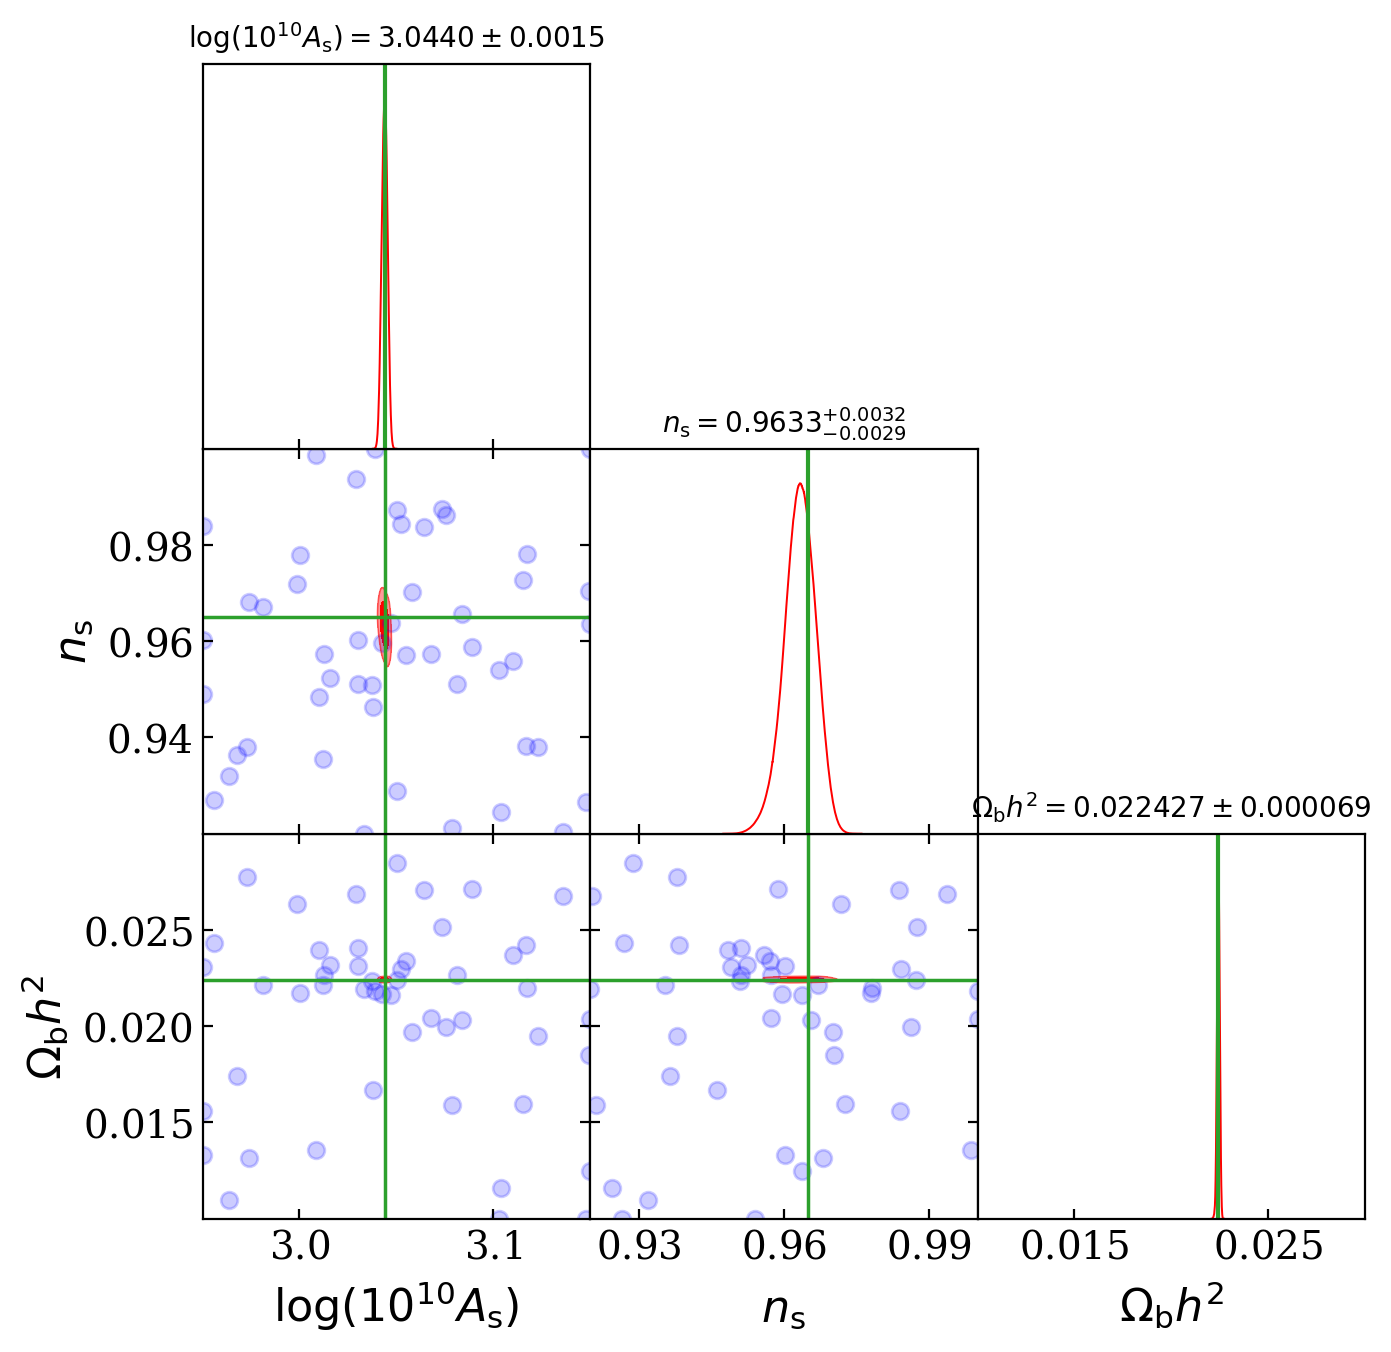

In [23]:
# ranges = dict(zip())

means  = [3.044,0.965,0.0224]

markers = dict(zip(cosmo.param_list,means))

gp_samples_nuts = MCSamples(samples=samples,names=cosmo.param_list, labels = cosmo.param_labels,ranges=cosmo.bounds_dict)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# for s in [gp_samples,gp_samples_nuts,true_samples]:
#         print(f"".join(f"{str(s.getInlineLatex(p,limit=1))}") for p in names)
# # g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 12
g.triangle_plot([gp_samples_nuts], cosmo.param_list,filled=[True,False,False],contour_colors=['red','blue','black'],title_limit=1,
                markers = markers,marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},param_limits=cosmo.bounds_dict) # type: ignore
#                                 legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution','HMC on GP fit'],
#                                 contour_lws=[1,1.5,1.],markers = dict(zip(names,f_mean)),
#                                 marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore


for i in range(cosmo.ndim):
    ax = g.subplots[i,i]
    ax.axvline(means[i], color='C2', ls='-')
    for j in range(i+1,cosmo.ndim):
        ax = g.subplots[j,i]
        ax.scatter(train_x[:,i],train_x[:,j],alpha=0.2,color='b',s=20)


### EI 

In [ ]:
input_file = './cosmo_input/LCDM_3D.yaml'

cosmo = sampler(ndim=3,cobaya_model=True,input_file=input_file,seed=1,max_steps=42, nstart=8,mc_points_size=32,acq)

cosmo.run()